## generate previous frames with pCO2 and fit it against ConvLSTM for multiple members

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean as cm
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import xarray as xr
from tensorflow import keras
import os

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

2024-07-16 21:11:30.149801: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2024-07-16 21:11:30.149822: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.14.1


###  CESM Previous Frame generation

In [3]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def custom_rmse2(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    + difference between sss
    """
    idx  = tf.not_equal(y_true, 0.0)
    idx2  = tf.equal(y_true, 0.0)
    
    y_pred1 = tf.boolean_mask(y_pred,idx)
    y_true1 = tf.boolean_mask(y_true,idx)
    y_true1 = tf.cast(y_true1, y_pred.dtype)
    
    
    return rmse1


In [4]:
# Reading Data
dir = "../../data/"
dir_name = "../../data/member_001"
data_nums = ["001", "002", "009", "010", "011", "012", "013", "014", "015", "016", "017", "018", "020",
             "021", "023", "024", "025", "030", "031", "034", "035", "101", "102", "103", "104"]

X_all = np.empty((0, 180, 360, 5))
y_all = np.empty((0, 180, 360))

for i in range(1):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num =data_nums[i])
    
    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    mld_images = preprocess_image_reduced(mld.MLD.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    y1 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
    #X1 = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images))
    X1 = X1.reshape((421,180,360,5),order='F')
    
    X_all = np.concatenate((X_all, X1))
    y_all = np.concatenate((y_all, y1))


/burg/glab/users/jn2808/ocean_co2/env/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
INPUT_SHAPE=X_all[0].shape
OUTPUT_SHAPE=y_all[0].shape

INPUT_SHAPE, X_all.shape, y_all.shape

((180, 360, 5), (421, 180, 360, 5), (421, 180, 360))

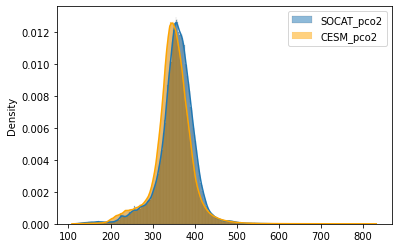

In [6]:
# Data distribution
import seaborn as sns

# SOCAT
_,_,_,_,_,_,_,_,socat = read_xarray("../../data/member_001",num ="001")
socat = np.nan_to_num(socat.pCO2_socat.data, 0.)
sns.histplot(socat[socat != socat.min()],stat='density',label='SOCAT_pco2',kde=True)

# GOBM
gobm = pco2.pCO2.data
sns.histplot(gobm[gobm != gobm.min()], stat='density',label='CESM_pco2',kde=True,color='orange')

plt.legend()
plt.show()

#### train

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")

base_model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.Dropout(0.2),
    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
])

myLearnRate=0.0005
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)

#rmse 13



base_model.compile(loss=custom_rmse, optimizer=custom_opt)

In [ ]:


model_path="../../models/base_model/u_net_dist.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = base_model.fit(X_all,y_all, epochs=200, 
                         validation_data=(X_all,y_all),
                         workers=-1,batch_size=16,
                         callbacks=callbacks)




#### load model

In [6]:
cnn_model = tf.keras.models.load_model('../../models/base_model/u_net_dist_final.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image= cnn_model.predict(X_all,verbose=1)
predicted_image[y_all==0]=0.0

2024-07-12 16:24:19.070699: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-12 16:24:19.129495: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2024-07-12 16:24:19.129521: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-12 16:24:19.129543: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (g124): /proc/driver/nvidia/version does not exist
2024-07-12 16:24:19.129951: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

14/14 [==============================] - 11s 766ms/step


(array([1.0010603e+07, 3.5959300e+05, 2.0432780e+06, 1.1634954e+07,
        2.9647080e+06, 2.2455400e+05, 3.0275000e+04, 9.1460000e+03,
        3.2200000e+03, 4.6900000e+02]),
 array([ -0.8939815,  23.458944 ,  47.81187  ,  72.164795 ,  96.51772  ,
        120.87065  , 145.22357  , 169.5765   , 193.92943  , 218.28236  ,
        242.63528  ], dtype=float32),
 <BarContainer object of 10 artists>)

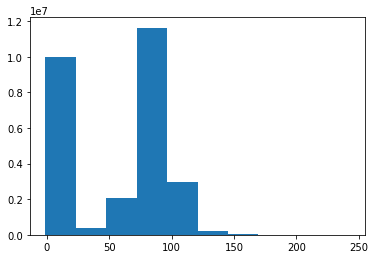

In [7]:
plt.hist(predicted_image.flatten())

In [8]:
print(custom_rmse(predicted_image,y_all))

tf.Tensor(2.9587349625538213, shape=(), dtype=float64)


In [9]:
predicted_image.shape

(421, 180, 360)

In [10]:
# # Create a date range from January 1982 to January 2017 (inclusive)
# dates = pd.date_range(start="1982-01-01", end="2017-02-01", freq='M')

# # Latitude and Longitude ranges
# latitudes = np.linspace(-89.5, 89.5, 180)
# longitudes = np.linspace(-179.5, 179.5, 360)

# # Creating an xarray Dataset
# predicted_image[predicted_image == 0.] = np.nan
# dataset = xr.Dataset(
#     {
#         "pco2": (("time", "latitude", "longitude"), predicted_image)
#     },
#     coords={
#         "time": dates,
#         "latitude": latitudes,
#         "longitude": longitudes
#     }
# )

# # Save asset
# dataset.to_netcdf('../../assets/global_pco2_monthly_1982_2017_unet.nc')

In [11]:
# # Plot a sample
# f, ax = plt.subplots()
# dataset.pco2.isel(time=-1).plot(cmap=cm.cm.thermal, ax=ax)

In [12]:

# y_true_all = np.empty((0,180,360))
# y_pred_all = np.empty((0,180,360))


# for i in range(3):
#     tmp = i+1
#     dir_name = dir + "member_" + str(data_nums[i])
#     chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(dir_name,num =data_nums[i])
#     y_true,y_pred = inverse_scale_image(predicted_image[421*(tmp-1):421*tmp],pco2t2.pCO2.data)
#     y_true_all = np.concatenate((y_true_all, y_true))
#     y_pred_all = np.concatenate((y_pred_all, y_pred))


# print("y_shapes:", y_true_all.shape, y_pred_all.shape)
# print("Full RMSE score:")
# a=custom_rmse(y_pred_all,y_true_all)
# print(a.numpy())


### Using the prediction as input in ConvLSTM

In [13]:
K = 6
X_all_conv = np.empty((0, K, 180, 360, 6))
y_all_conv = np.empty((0, K, 180, 360, 1))
X_index=np.lib.stride_tricks.sliding_window_view(range(421),K)

tmp = 1

for i in range(1):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num=data_nums[i])

    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    pco2 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    
    y = np.expand_dims(pco2[X_index][1:], axis=4)
    
    X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image[421*(tmp-1):421*tmp]))
    tmp+=1
    X = X.reshape((421,180,360,6),order='F')
    X = X[X_index][:-1]
    
    X_all_conv = np.concatenate((X_all_conv, X))
    y_all_conv = np.concatenate((y_all_conv, y))


shuffle_ind = (np.arange(X_all_conv.shape[0]))
np.random.shuffle(shuffle_ind)
X_all_conv = np.array(X_all_conv)[shuffle_ind.astype(int)]
y_all_conv = np.array(y_all_conv)[shuffle_ind.astype(int)]

X_all_conv.shape, y_all_conv.shape

((415, 6, 180, 360, 6), (415, 6, 180, 360, 1))

In [14]:
INPUT_SHAPE=X_all_conv[0].shape
OUTPUT_SHAPE=y_all_conv[0].shape

INPUT_SHAPE

(6, 180, 360, 6)

#### Train

In [14]:
tf.keras.backend.clear_session()
from functools import partial


DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)



model = keras.models.Sequential([
    DefaultConvLSTM2D(input_shape=INPUT_SHAPE),
    DefaultConvLSTM2D(kernel_size=(4,4)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(2,2)),
    keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),activation="elu", padding="same")
    
])


model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(
        learning_rate=0.001),
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 180, 360, 32)   121728    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 180, 360, 32)   131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 180, 360, 32)   32896     
_________________________________________________________________
conv3d (Conv3D)              (None, 1, 180, 360, 1)    865       
Total params: 286,817
Trainable params: 286,753
Non-trainable params: 64
_________________________________________________________________


In [ ]:
# Train on non-residual
model_path=f"../../models/ConvLSTM_with_pco2_{K}mon.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 8

# Fit the model to the training data.
hist = model.fit(
    X_all_conv,
    y_all_conv,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_all_conv,y_all_conv),
    callbacks=callbacks,
)

In [ ]:
# Train on anomaly
model_path=f"../../models/ConvLSTM_with_pco2_{K}mon_anomaly.h5"
y_all_conv_anom = y_all_conv - y_all_conv.mean()

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 8

# Fit the model to the training data.
hist = model.fit(
    X_all_conv,
    y_all_conv_anom,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_all_conv,y_all_conv_anom),
    callbacks=callbacks,
)

### Result for CONVLSTM

In [15]:
def inverse_scale_image_nfp(arr, df, is_anomaly):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    if is_anomaly:
        df = df - df.mean()
        
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [16]:
convlstm_model_path = f"../../models/ConvLSTM_with_pco2_{K}mon.h5"
convlstm_anomaly_model_path = f"../../models/ConvLSTM_with_pco2_{K}mon_anomaly.h5"

convlstm_model = tf.keras.models.load_model(convlstm_model_path, custom_objects={'custom_rmse':custom_rmse})
convlstm_anomaly_model = tf.keras.models.load_model(convlstm_anomaly_model_path, custom_objects={'custom_rmse':custom_rmse})

In [17]:

dir_name = "../../data/member_009"
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(
    dir_name,num="009")

tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][1:])

y_true_full = np.expand_dims(tmp,axis=4)
print(y_true_full.shape)
coord = (y_true_full==0.0)

chl_images = preprocess_image_reduced(chl.Chl.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
y1 = preprocess_image_reduced(pco2t2.pCO2.data)
dist_map = preprocess_image_reduced(dist_map)
X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
X1 = X1.reshape((421,180,360,5),order='F')

predicted_image= cnn_model.predict(X1,verbose=1)
predicted_image[y1==0]=0.0


X_tmp = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image))
X_tmp= X_tmp.reshape((421,180,360,6),order='F')


X2 = X_tmp[X_index][:-1]

X2.shape

(415, 6, 180, 360, 1)
14/14 [==============================] - 11s 759ms/step


(415, 6, 180, 360, 6)

In [18]:
predicted_frames = convlstm_model.predict(X2)
predicted_anomaly_frames = convlstm_anomaly_model.predict(X2)

y_true,y_pred=inverse_scale_image_nfp(predicted_frames, pco2t2.pCO2.data, is_anomaly=False)
y_anomaly_true,y_anomaly_pred=inverse_scale_image_nfp(predicted_anomaly_frames, pco2t2.pCO2.data, is_anomaly=True)

y_pred[coord], y_anomaly_pred[coord]=0.0, 0.0
y_true[coord], y_anomaly_true[coord]=0.0, 0.0

print("Full RMSE score:")
a=custom_rmse(y_true[:,K-1],y_pred[:,K-1]) # RMSE 1 17.73 # RMSE 3 month: 14.52 # RMSE 6 month: 13.133677
print(a)


Full RMSE score:
tf.Tensor(13.133592, shape=(), dtype=float32)


In [19]:
y1=y1[X_index][:-1]
y1 = np.expand_dims(y1,axis=4)
y1.shape

(415, 6, 180, 360, 1)

In [20]:
# # Create a date range from July 1982 to January 2017 (inclusive)
# dates = pd.date_range(start="1982-07-01", end="2017-02-01", freq='M')

# # Latitude and Longitude ranges
# latitudes = np.linspace(-89.5, 89.5, 180)
# longitudes = np.linspace(-179.5, 179.5, 360)

# # Creating an xarray Dataset
# dataset = xr.Dataset(
#     {
#         "pco2": (("time", "latitude", "longitude"), predicted_frames[:,K-1,:,:,0])
#     },
#     coords={
#         "time": dates,
#         "latitude": latitudes,
#         "longitude": longitudes
#     }
# )

# # Save asset
# dataset = xr.where(y_true[:,0,:,:,0] == 0., np.nan, dataset) # cover land
# dataset.to_netcdf('../../assets/global_pco2_monthly_1982_2017_convlstm.nc')

In [21]:
# # Plot a sample
# f, ax = plt.subplots()
# dataset.pco2.isel(time=-1).plot(cmap=cm.cm.thermal, ax=ax)

(415,)


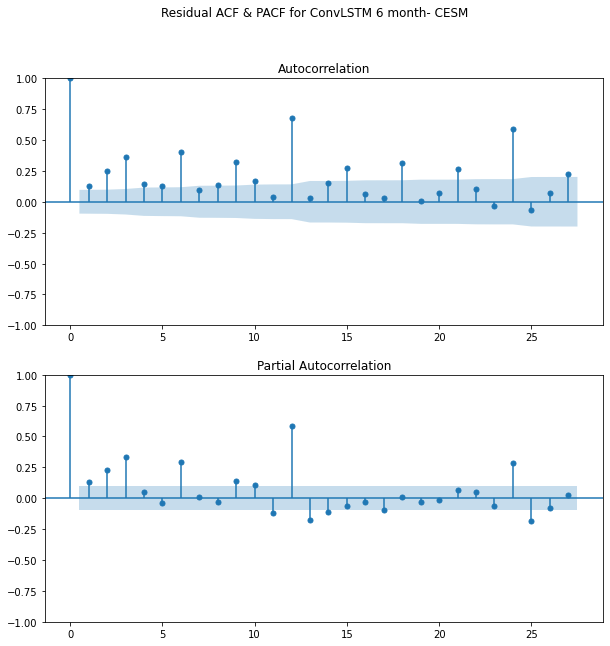

In [22]:
y_true[coord], y_anomaly_pred[coord]=np.nan, np.nan
y_pred[coord], y_anomaly_true[coord]=np.nan, np.nan

res = y_true[:,K-1]-y_pred[:,K-1]

avg_time_res_convlstm = np.nanmean(res, axis=(1,2,3))
print(avg_time_res_convlstm.shape)

fig = pyplot.figure(figsize = (10,10))
pyplot.subplot(211)
plot_acf(avg_time_res_convlstm, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(avg_time_res_convlstm, ax=pyplot.gca())

fig.suptitle(f"Residual ACF & PACF for ConvLSTM {K} month- CESM")

# plt.savefig(f"../../assets/figure7_convLSTM_cesm_acf_{K}mon.jpg")
pyplot.show()

In [23]:
xlabels = []
start_year = 2000

for i in range(len(avg_time_res_convlstm[218:])):
    if i%12==0:
        xlabels.append(str(start_year))
        start_year+=1
    else:
        xlabels.append("")

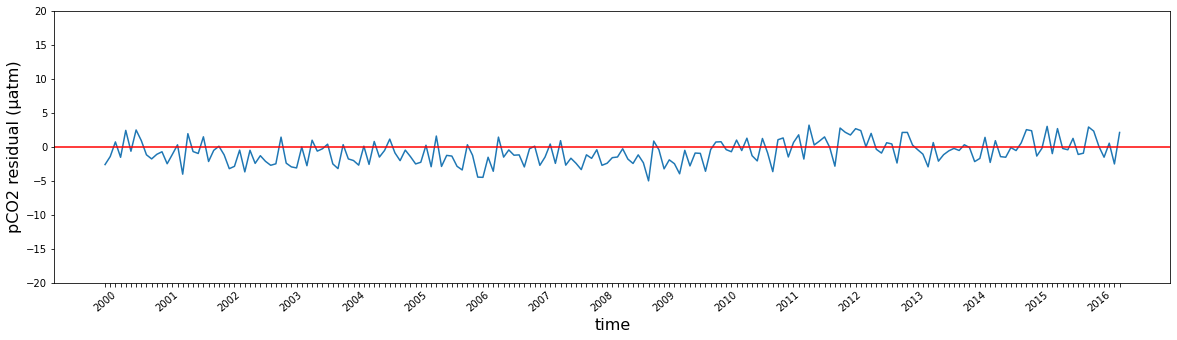

In [24]:
# Residual over time
fig = pyplot.figure(figsize = (20,5))
plt.plot(avg_time_res_convlstm[218:])
plt.xticks(ticks=range((420-218-(K-1))),labels=xlabels,rotation=40)
plt.ylim([-20, 20])
plt.axhline(y = 0.0,color = 'r', linestyle = '-')
plt.xlabel('time', size=16)
plt.ylabel('pCO2 residual (μatm)', size=16)
# fig.suptitle(f"ConvLSTM {K} month - Residual over Time")
plt.savefig(f"../../assets/figure7_convLSTM_residual_{K}mon.jpg", bbox_inches='tight', dpi=200)
plt.show();

In [25]:
res.shape

(415, 180, 360, 1)

In [26]:
np.absolute(np.nanmean(res[218:], axis=(0,3))).shape

/local/ipykernel_2510192/2823793438.py:1: RuntimeWarning: Mean of empty slice
  np.absolute(np.nanmean(res[218:], axis=(0,3))).shape


(180, 360)

/local/ipykernel_2510192/332778863.py:2: RuntimeWarning: Mean of empty slice
  avg_space_res_convlstm = np.absolute(np.nanmean(res[218:], axis=(0,3)))


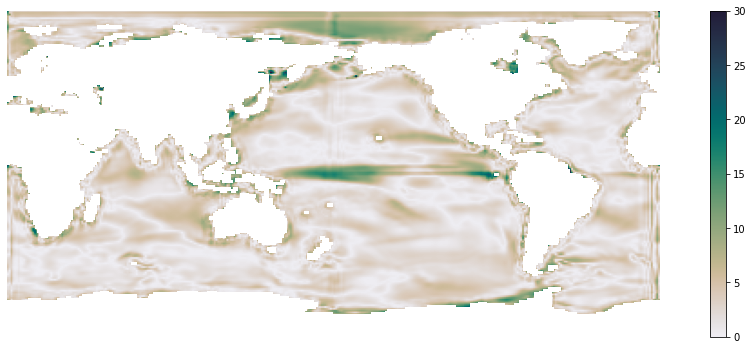

In [27]:
# Residual over space
avg_space_res_convlstm = np.absolute(np.nanmean(res[218:], axis=(0,3)))

figure, axis = plt.subplots(1, figsize=(18,6))
im0 = axis.imshow(np.flipud(avg_space_res_convlstm),cmap = cm.cm.rain,label="Residual", vmin=0, vmax=30)
cbar0 = figure.colorbar(im0, ax=axis)
axis.axis('off')

plt.subplots_adjust(wspace=0.1)
# plt.savefig(f"../../assets/figure7_convLSTM_residual_{K}mon_space.jpg", bbox_inches='tight', dpi=200);

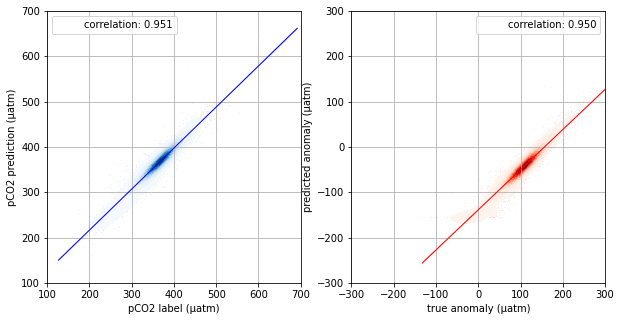

In [28]:
# Flatten the data
y_true_flat, y_anomaly_true_flat = y_true[218:, K-1].flatten(), y_anomaly_true[218:, K-1].flatten()
y_pred_flat, y_anomaly_pred_flat = y_pred[218:, K-1].flatten(), y_anomaly_pred[218:, K-1].flatten()

# Remove nan entries
valid_mask = np.logical_and(~np.isnan(y_true_flat), ~np.isnan(y_pred_flat))

# Construct dataframe with truth/pred/residual
combined_tmp = pd.DataFrame({
    'pCO2': y_true_flat[valid_mask],
    'pred': y_pred_flat[valid_mask],
    'pCO2_anomaly': y_anomaly_true_flat[valid_mask],
    'pred_anomaly': y_anomaly_pred_flat[valid_mask]
})

sample_data = combined_tmp.sample(n=10000)

f, ax = plt.subplots(1, 2, figsize=(10, 5))

# Define limits for the plots
limits_1 = [100, 700]
limits_2 = [-300, 300]

# First: pred vs truth
correlation = np.corrcoef(sample_data[['pCO2']].values.squeeze(), sample_data[['pred']].values.squeeze())[0, 1]

sns.scatterplot(data=sample_data, x='pCO2', y='pred', s=0.1, ax=ax[0])
sns.kdeplot(data=sample_data, x='pCO2', y='pred', fill=True, cmap='Blues', ax=ax[0], label=f'correlation: {correlation:.3f}')
sns.regplot(data=sample_data, x='pCO2', y='pred', scatter=False, ax=ax[0], color='blue', line_kws={"linewidth": 1})
ax[0].set_xlabel('pCO2 label (μatm)')
ax[0].set_ylabel('pCO2 prediction (μatm)')
ax[0].set_xlim(limits_1)
ax[0].set_ylim(limits_1)
ax[0].legend()
ax[0].grid(True)

# Second: residual vs truth
correlation = np.corrcoef(sample_data[['pCO2_anomaly']].values.squeeze(), sample_data[['pred_anomaly']].values.squeeze())[0, 1]

sns.scatterplot(data=sample_data, x='pCO2_anomaly', y='pred_anomaly', color='red', s=0.1, ax=ax[1])
sns.kdeplot(data=sample_data, x='pCO2_anomaly', y='pred_anomaly', fill=True, cmap='Reds', ax=ax[1], label=f'correlation: {correlation:.3f}')
sns.regplot(data=sample_data, x='pCO2_anomaly', y='pred_anomaly', scatter=False, ax=ax[1], color='red', line_kws={"linewidth": 1})
ax[1].set_xlabel('true anomaly (μatm)')
ax[1].set_ylabel('predicted anomaly (μatm)')
ax[1].set_xlim(limits_2)
ax[1].set_ylim(limits_2)
ax[1].legend()
ax[1].grid(True)

plt.savefig(f"../../assets/figure7_convLSTM_residual_{K}mon_scatter.jpg", bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
np.mean(avg_time_res_convlstm), np.var(avg_time_res_convlstm)
# 1 mon: (-8.05091971186212, 7.825130940677933)
# 3 mon: (0.19049866223339668, 4.744850814381859)
# 6 mon: (0.08857827863591704, 3.2171045340551534)